In [1]:
import numpy as np
from uncertainties import umath 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from astropy.io import fits
from astropy.io import ascii
from astropy.cosmology import WMAP9 as cosmo
from scipy.constants import parsec as prsc
from scipy.constants import c as lightspeed
import astropy.units as u
import matplotlib.ticker as ticker
import pandas as pd
from uncertainties import ufloat_fromstr
from uncertainties import ufloat
from uncertainties import umath
from matplotlib.ticker import ScalarFormatter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import dtale
from scipy import stats
from sklearn import model_selection, metrics
from uncertainties import ufloat_fromstr

In [52]:
cb_gals = pd.read_csv('cb_galaxies_data.csv')
cb_gals.hg2hb = np.array([ufloat_fromstr(r) for r in cb_gals.hg2hb])


# Make all ratios greater than 0.469 -> 0
def physical_r(r):
    is_physical = ((r.n - r.s) <= 0.469) & (r.n > 0)
    return is_physical

#cb_gals['hg2hb_phys'] = np.array([r if physical_r(r) else ufloat(0,0) for r in cb_gals.hg2hb])

cb_gals

,gal_name,sfr,sfr_u,s2n,logmass,mass_up_u,mas_low_u,m_tremonti,sdss_v50,sdss_v98,trem_v50,trem_v98,swept_up,mm_v50,mm_v98,hb_flux,hg_flux,hg2hb
0,J0826+4305,10.60,1.20,8.83,10.71,0.02,0.01,11.03,850.21,1220.36,1131.2,1456.2,1.0,995.96,1319.68,52+/-6,25+/-4,0.49+/-0.09
1,J0901+0314,6.50,0.50,13.00,10.59,0.01,0.01,10.98,NaN,NaN,1210.1,1575.4,0.0,1199.32,1506.72,61+/-4,20+/-4,0.33+/-0.07
2,J0905+5759,14.30,1.50,9.53,10.75,0.02,0.02,10.74,2476.77,2913.18,2395.3,2884.8,1.0,2350.23,2556.89,46+/-5,21.6+/-3.1,0.46+/-0.08
3,J0944+0930,5.20,0.70,7.43,10.74,0.04,0.03,10.69,1241.00,1747.79,1172.4,1878.3,1.0,1205.41,1654.76,39+/-5,17+/-4,0.43+/-0.12
4,J1107+0417,5.80,0.40,14.50,10.68,0.02,0.02,10.73,1626.14,1995.31,1359.8,2015.6,NaN,1419.17,1930.34,52+/-4,23+/-4,0.44+/-0.09
5,J1125-0145,2.50,0.80,3.13,NaN,NaN,NaN,11.05,NaN,NaN,1968.4,2120.4,0.0,NaN,NaN,17+/-5,13+/-5,0.8+/-0.4
6,J1219+0336,3.80,0.50,7.60,11.34,0.02,0.02,10.71,1586.07,1818.08,1543.7,1962.6,1.0,1575.30,1799.78,38+/-5,37+/-8,0.97+/-0.24
7,J1232+0723,2.48,0.32,7.75,NaN,NaN,NaN,10.89,44.93,347.02,145.6,839.6,0.0,250.12,675.40,32+/-4,16+/-5,0.51+/-0.16
8,J1341-0321,19.70,1.60,12.31,10.61,0.02,0.02,10.98,711.96,1700.50,766.9,1995.2,0.0,618.22,1086.92,76+/-6,28+/-5,0.36+/-0.07
9,J1450+4621,5.00,4.00,1.25,NaN,NaN,NaN,10.94,406.40,1189.78,759.6,1733.7,1.0,482.23,1444.45,11+/-11,-2+/-4,-0.2+/-0.4


## Attenuation and Correction

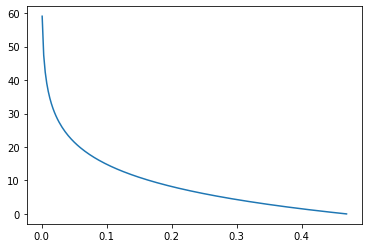

In [31]:
def func(r):
    return (-2.5 / (4.60 - 5.12)) * np.log10(0.469 / r) * 4.60
x = np.linspace(10**-3,0.469,200)
y = func(x)
plt.plot(x, y)

In [137]:
def attenuate(current_ratio):
    if current_ratio <= 0:
        A_hbeta = np.nan
    elif current_ratio >= 0.469:
        A_hbeta = 0
    else:
        A_hbeta = (-2.5 / (4.60 - 5.12)) * np.log10(0.469 / current_ratio) * 4.60

    return A_hbeta

# Categorize each galaxy based on Hg/Hb ratio and S/N
def categorize(row):
    cat = 0
    s2n_ok = row.hg2hb.s < 0.1
    ab_morethan_0 = (row.ahb_n > 0) & (row.ahb_h > 0) & (row.ahb_l > 0)
    if ab_morethan_0:
        cat = 1
    elif (not ab_morethan_0) & (s2n_ok):
        cat = 2
    elif (not ab_morethan_0) & (not s2n_ok):
        cat = 3
                
    return cat 

In [138]:
dustcorr_df = cb_gals[['gal_name', 'hg2hb']].copy()
# Attenuation values
dustcorr_df['ahb_n'] = np.array([attenuate(r.n) for r in cb_gals.hg2hb])
dustcorr_df['ahb_h'] = np.array([attenuate(r.n-(r.s)) for r in cb_gals.hg2hb])
dustcorr_df['ahb_l'] = np.array([attenuate(r.n+(r.s)) for r in cb_gals.hg2hb])
# Dust correction values
dustcorr_df['hb_corr'] = 10.**(dustcorr_df.ahb_n/2.5)
dustcorr_df['hb_corr_hi'] = 10.**(dustcorr_df.ahb_h/2.5)
dustcorr_df['hb_corr_lo'] = 10.**(dustcorr_df.ahb_l/2.5)
# Categorize
dustcorr_df['cats'] = np.array([categorize(dustcorr_df.iloc[i,:]) for i in range(dustcorr_df.shape[0])])

dustcorr_df

,gal_name,hg2hb,ahb_n,ahb_h,ahb_l,hb_corr,hb_corr_hi,hb_corr_lo,cats
0,J0826+4305,0.49+/-0.09,0.000000,1.528457,0.000000,1.000000,4.086796,1.000000,2
1,J0901+0314,0.33+/-0.07,3.376110,5.665950,1.528457,22.410118,184.663110,4.086796,1
2,J0905+5759,0.46+/-0.08,0.186101,2.021108,0.000000,1.186972,6.433441,1.000000,2
3,J0944+0930,0.43+/-0.12,0.833847,3.976593,0.000000,2.155454,38.961627,1.000000,3
4,J1107+0417,0.44+/-0.09,0.613042,2.810972,0.000000,1.758802,13.316454,1.000000,2
5,J1125-0145,0.8+/-0.4,0.000000,1.528457,0.000000,1.000000,4.086796,1.000000,3
6,J1219+0336,0.97+/-0.24,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3
7,J1232+0723,0.51+/-0.16,0.000000,2.810972,0.000000,1.000000,13.316454,1.000000,3
8,J1341-0321,0.36+/-0.07,2.540402,4.617136,0.833847,10.379124,70.283664,2.155454,1
9,J1450+4621,-0.2+/-0.4,NaN,NaN,8.185851,NaN,NaN,1880.791139,3


## SFR Ratio Calculation

In [139]:
# Creating arrays with the Tremonti table
ChristyTablePath = 'files/hizea_wind_ancillary.fit'
#ChristyTablePath = '/Users/adiamond/data/j2118-nebula/hizea_wind_ancillary.fit'
ChristyTable = fits.open(ChristyTablePath)
ShortNames = ChristyTable[1].data['SHORT_NAME']
ChristyMass = ChristyTable[1].data['MASS']
ChristySFR = ChristyTable[1].data['SFR']
ChristyV50 = ChristyTable[1].data['VAVG']
ChristyV98 = ChristyTable[1].data['VMAX']
ChristyAge = ChristyTable[1].data['LW_AGE']
ChristyZ = ChristyTable[1].data['Z']

In [140]:
bradna_Cmask = [True if x in cb_gals.gal_name.tolist() else False for x in ShortNames]
TremSFR = 10**ChristySFR  # since ChristySFR is log(SFR)
tlsfr = 10**(ChristySFR-0.2)
thsfr = 10**(ChristySFR+0.2)
TremUpperSFRUnc = thsfr - TremSFR
TremLowerSFRUnc = TremSFR - tlsfr
# Propagating uncertainty for ratios
TremSFR_u = np.array([ufloat(ChristySFR[x], 0.2) for x in range(len(ChristySFR))])
oursfr_u = np.array([ufloat(cb_gals.sfr[x], cb_gals.sfr_u[x]) for x in range(len(cb_gals.sfr))])
SFR_ratio = (10**TremSFR_u[bradna_Cmask])/oursfr_u
SFR_ratio_n = np.array([x.n for x in SFR_ratio])
SFR_ratio_s = np.array([x.s for x in SFR_ratio])

## Plotting

In [141]:
dustcorr_df['sfr_r_n'] = SFR_ratio_n
dustcorr_df['sfr_r_s'] = SFR_ratio_s
dustcorr_df['hb_corr'] = dustcorr_df.hb_corr
dustcorr_df['hb_lo_err'] = dustcorr_df.hb_corr-dustcorr_df.hb_corr_lo
dustcorr_df['hb_hi_err'] = dustcorr_df.hb_corr_hi-dustcorr_df.hb_corr
dustcorr_df['swept_up'] = cb_gals.swept_up.replace(np.nan, 'n/a')

dustcorr_df

,gal_name,hg2hb,ahb_n,ahb_h,ahb_l,hb_corr,hb_corr_hi,hb_corr_lo,cats,sfr_r_n,sfr_r_s,hb_lo_err,hb_hi_err,swept_up
0,J0826+4305,0.49+/-0.09,0.000000,1.528457,0.000000,1.000000,4.086796,1.000000,2,14.792065,7.014806,0.000000,3.086796,1
1,J0901+0314,0.33+/-0.07,3.376110,5.665950,1.528457,22.410118,184.663110,4.086796,1,13.228009,6.176122,18.323322,162.252992,0
2,J0905+5759,0.46+/-0.08,0.186101,2.021108,0.000000,1.186972,6.433441,1.000000,2,10.647205,5.028806,0.186972,5.246469,1
3,J0944+0930,0.43+/-0.12,0.833847,3.976593,0.000000,2.155454,38.961627,1.000000,3,18.568379,8.908899,1.155454,36.806173,1
4,J1107+0417,0.44+/-0.09,0.613042,2.810972,0.000000,1.758802,13.316454,1.000000,2,7.689572,3.580668,0.758802,11.557653,n/a
5,J1125-0145,0.8+/-0.4,0.000000,1.528457,0.000000,1.000000,4.086796,1.000000,3,36.894595,20.689808,0.000000,3.086796,0
6,J1219+0336,0.97+/-0.24,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3,38.102581,18.249066,0.000000,0.000000,1
7,J1232+0723,0.51+/-0.16,0.000000,2.810972,0.000000,1.000000,13.316454,1.000000,3,16.151471,7.724478,0.000000,12.316454,0
8,J1341-0321,0.36+/-0.07,2.540402,4.617136,0.833847,10.379124,70.283664,2.155454,1,6.022474,2.816254,8.223670,59.904540,0
9,J1450+4621,-0.2+/-0.4,NaN,NaN,8.185851,NaN,NaN,1880.791139,3,98.399892,90.830932,NaN,NaN,1


### All galaxies; color by category

(5.420226617851459, 359.3238486225088)

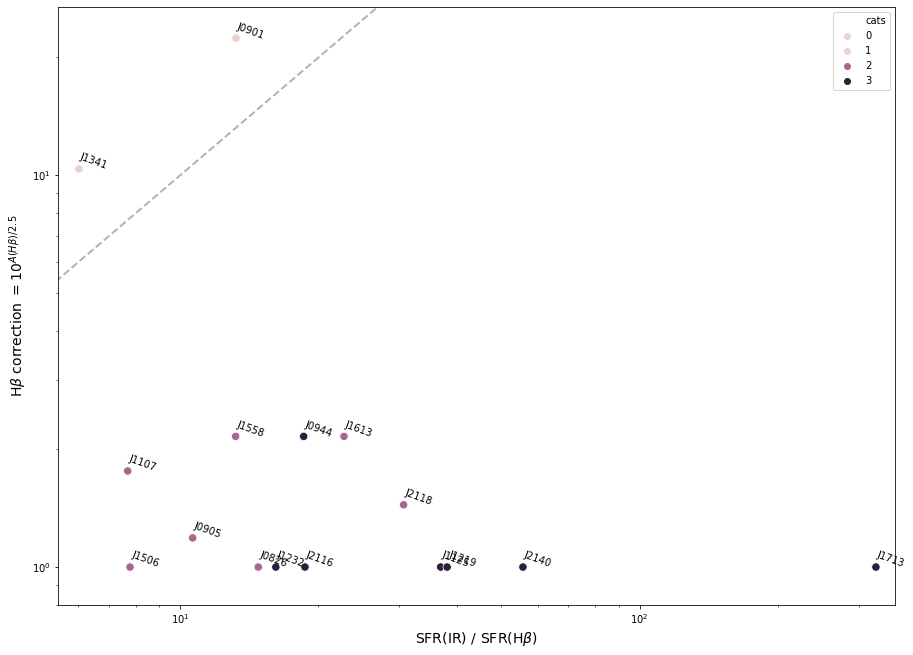

In [146]:
fig, ax = plt.subplots(figsize=(15,11))
g = sns.scatterplot(ax = ax, data = dustcorr_df, s=70,
                x='sfr_r_n',
                y='hb_corr',
                hue='cats')
ax.plot(np.linspace(0, 150, 10), np.linspace(0, 150, 10), "--", lw=2, color="black", alpha=0.3)
for i in range(dustcorr_df.shape[0]):
    ax.annotate(dustcorr_df.iloc[i].gal_name[:5],
                (dustcorr_df.sfr_r_n[i], dustcorr_df.hb_corr[i]), fontsize=10, rotation=-20)
ax.loglog()
ax.set_ylabel(r"H$\beta$ correction $=10^{A(H\beta)/2.5}$", fontsize=14)
ax.set_xlabel(r"SFR(IR) / SFR(H$\beta$)", fontsize=14)

ax.set_ylim([dustcorr_df.hb_corr.min()*0.8, dustcorr_df.hb_corr.max()*1.2])
ax.set_xlim([dustcorr_df.sfr_r_n.min()*0.9, dustcorr_df.sfr_r_n.max()*1.1])

### All Galaxies, include error bars

Text(0, 0.5, 'H$\\beta$ correction $=10^{A(H\\beta)/2.5}$')

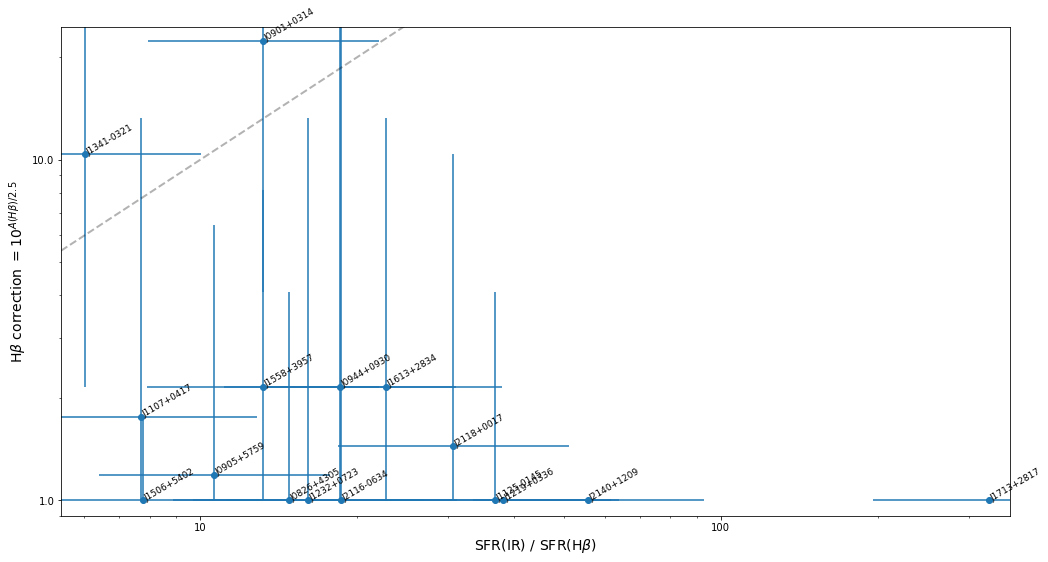

In [143]:
# -------------- Plotting figure Hbeta correction vs SFR ratio for AAS 2019 poster
aasfig = plt.figure(figsize=(17, 9))
plt.tight_layout()

ax6 = aasfig.add_subplot(1, 1, 1)
ax6.plot(np.linspace(0, 150, 10), np.linspace(0, 150, 10), "--", lw=2, color="black", alpha=0.3)

ax6.scatter(dustcorr_df.sfr_r_n, dustcorr_df.hb_corr)
ax6.errorbar(dustcorr_df.sfr_r_n, dustcorr_df.hb_corr,
             xerr=[dustcorr_df.sfr_r_n*0.40, dustcorr_df.sfr_r_n*0.67],
             yerr=[dustcorr_df.hb_corr-dustcorr_df.hb_corr_lo, 
                   dustcorr_df.hb_corr_hi-dustcorr_df.hb_corr],
             ls='none')

ax6.loglog()

for i in range(dustcorr_df.shape[0]):
    ax6.annotate(dustcorr_df.gal_name[i], (dustcorr_df.sfr_r_n[i], dustcorr_df.hb_corr[i]), fontsize=9, rotation=30)

for axis in [ax6.xaxis, ax6.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax6.set_xlabel(r"SFR(IR) / SFR(H$\beta$)", fontsize=14)
ax6.set_ylim([dustcorr_df.hb_corr.min()*0.9, dustcorr_df.hb_corr.max()*1.1])
ax6.set_xlim([dustcorr_df.sfr_r_n.min()*0.9, dustcorr_df.sfr_r_n.max()*1.1])
ax6.set_ylabel(r"H$\beta$ correction $=10^{A(H\beta)/2.5}$", fontsize=14)

### Galaxies in category 1

(1, 50)

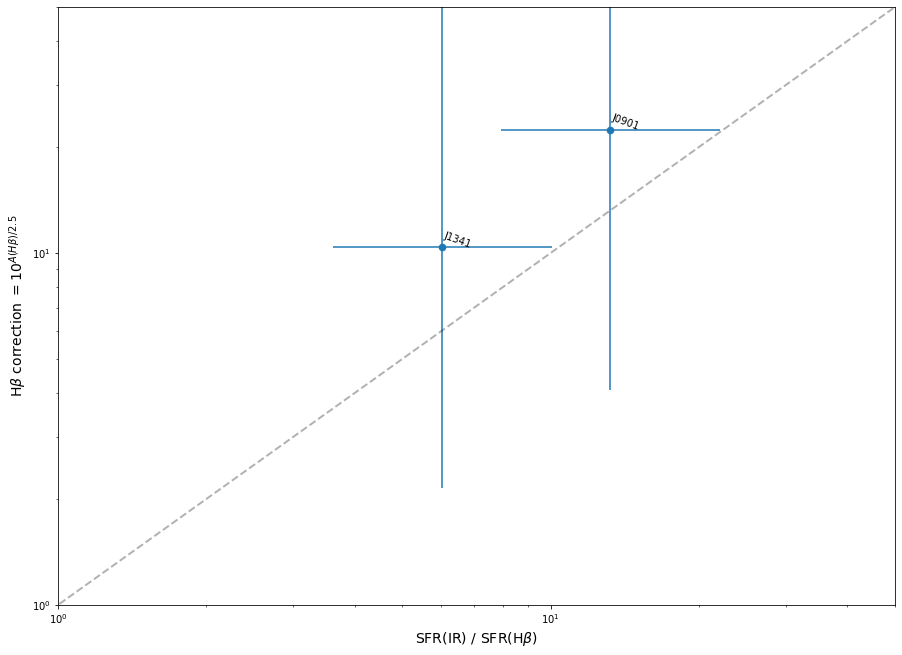

In [150]:
df = dustcorr_df[dustcorr_df.cats == 1].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15,11))

ax.errorbar(df.sfr_r_n, df.hb_corr,
             xerr=[df.sfr_r_n*0.40, df.sfr_r_n*0.67],
             yerr=[df.hb_corr-df.hb_corr_lo, 
                   df.hb_corr_hi-df.hb_corr],
             ls='none')

g = sns.scatterplot(ax = ax, data = df, s=70,
                x='sfr_r_n',
                y='hb_corr')
ax.plot(np.linspace(0, 150, 10), np.linspace(0, 150, 10), "--", lw=2, color="black", alpha=0.3)


for i in range(df.shape[0]):
    ax.annotate(df.iloc[i].gal_name[:5],
                (df.sfr_r_n[i], df.hb_corr[i]), fontsize=10, rotation=-20)

ax.loglog()
ax.set_ylabel(r"H$\beta$ correction $=10^{A(H\beta)/2.5}$", fontsize=14)
ax.set_xlabel(r"SFR(IR) / SFR(H$\beta$)", fontsize=14)

ax.set_ylim([1, 50])
ax.set_xlim([1, 50])

### Galaxies in category 2

(1, 50)

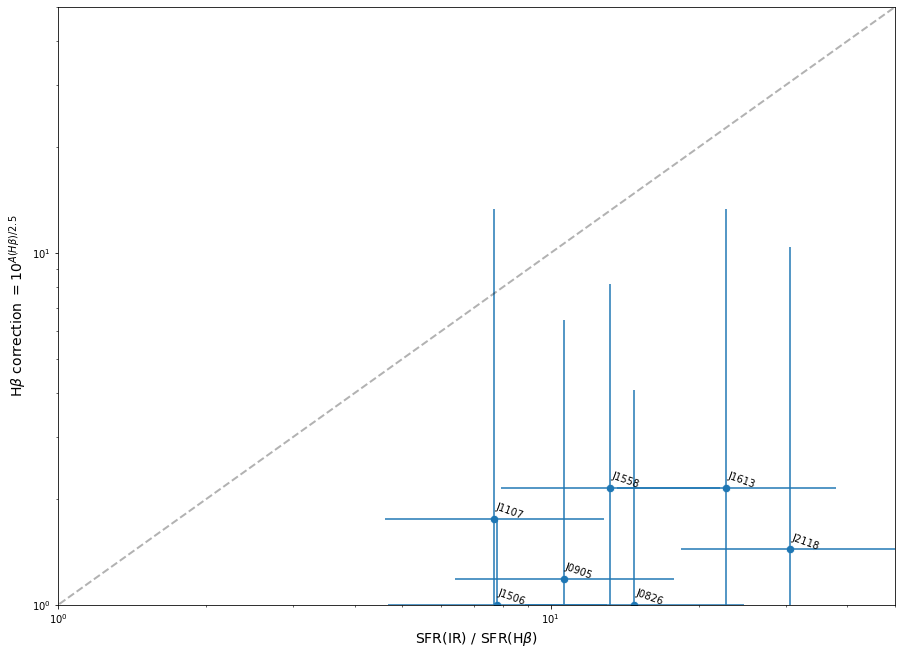

In [153]:
df = dustcorr_df[dustcorr_df.cats == 2].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15,11))

ax.errorbar(df.sfr_r_n, df.hb_corr,
             xerr=[df.sfr_r_n*0.40, df.sfr_r_n*0.67],
             yerr=[df.hb_corr-df.hb_corr_lo, 
                   df.hb_corr_hi-df.hb_corr],
             ls='none')

g = sns.scatterplot(ax = ax, data = df, s=70,
                x='sfr_r_n',
                y='hb_corr')
ax.plot(np.linspace(0, 150, 10), np.linspace(0, 150, 10), "--", lw=2, color="black", alpha=0.3)


for i in range(df.shape[0]):
    ax.annotate(df.iloc[i].gal_name[:5],
                (df.sfr_r_n[i], df.hb_corr[i]), fontsize=10, rotation=-20)

ax.loglog()
ax.set_ylabel(r"H$\beta$ correction $=10^{A(H\beta)/2.5}$", fontsize=14)
ax.set_xlabel(r"SFR(IR) / SFR(H$\beta$)", fontsize=14)

ax.set_ylim([1, 50])
ax.set_xlim([1, 50])

### Galaxies type 3

(1, 50)

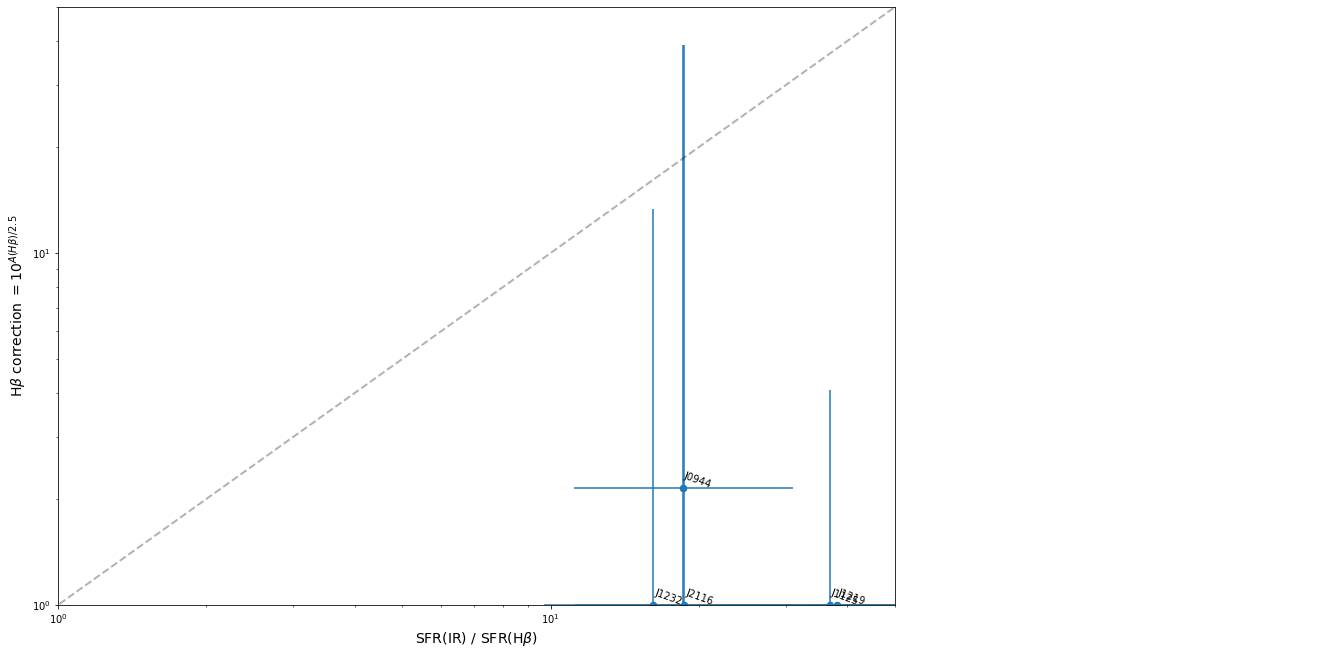

In [154]:
df = dustcorr_df[dustcorr_df.cats == 3].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15,11))

ax.errorbar(df.sfr_r_n, df.hb_corr,
             xerr=[df.sfr_r_n*0.40, df.sfr_r_n*0.67],
             yerr=[df.hb_corr-df.hb_corr_lo, 
                   df.hb_corr_hi-df.hb_corr],
             ls='none')

g = sns.scatterplot(ax = ax, data = df, s=70,
                x='sfr_r_n',
                y='hb_corr')
ax.plot(np.linspace(0, 150, 10), np.linspace(0, 150, 10), "--", lw=2, color="black", alpha=0.3)


for i in range(df.shape[0]):
    ax.annotate(df.iloc[i].gal_name[:5],
                (df.sfr_r_n[i], df.hb_corr[i]), fontsize=10, rotation=-20)

ax.loglog()
ax.set_ylabel(r"H$\beta$ correction $=10^{A(H\beta)/2.5}$", fontsize=14)
ax.set_xlabel(r"SFR(IR) / SFR(H$\beta$)", fontsize=14)

ax.set_ylim([1, 50])
ax.set_xlim([1, 50])

# Plotting by Categories
So, for each galaxy, if the ratio is at its 1 sigma upper limit, what is A_Hbeta (and we'll have to set this to A_hbeta=0 for ratios above 0.469)? And if the ratio is at its 1 sigma lower limit, what is A_Hbeta?  
  
So I think there will be three categories of objects: (1) we can confidently say A_hbeta > 0, (2) we can't rule out A_hbeta = 0, but the S/N is OK, (3) we can't rule out A_hbeta = 3, and the S/N is not good (edited)  
  
For category (3), I could imagine creating a separate plot with just these objects, showing that the upper limits on A_hbeta for these low S/N objects are also huge. Then we could exclude category (3) from subsequent analysis